# Cosine schedule

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.fid import *

In [ ]:
from fastprogress import progress_bar

In [ ]:
from diffusers import UNet2DModel

In [ ]:
set_seed(1103, False)
mpl.rcParams['image.cmap'] = 'gray'
logging.disable(logging.WARNING)

In [ ]:
fm_x, fm_y = "image", "label"
name = "fashion_mnist"
ds = load_dataset(name)

In [ ]:
@inplace
def transformi(b):
    b["image"] = [TF.pad(TF.to_tensor(i), padding=2, fill=0, padding_mode="constant") - 0.5 for i in b["image"]]
dst = ds.with_transform(transformi)

bs = 64
dls = DataLoaders.from_dd(dst, bs)
xb, yb = next(iter(dls.train))

In [ ]:
def abar(t):
    return (t * (math.pi / 2)).cos() ** 2

In [ ]:
def inv_abar(x):
    return x.sqrt().acos() * (2 / math.pi)

In [ ]:
(-1,) + (1,) * (len(xb.shape) - 1)

(-1, 1, 1, 1)

In [ ]:
def add_noise(x):
    device = x.device
    bs = x.shape[0]

    # t = torch.randint(0, schedule.n_steps, (bs,), dtype=torch.int64)
    t = torch.rand((bs,), device=device)
    # alpha_bar_t = schedule.alphas_bar[t][:, None, None, None].to(device)
    alpha_bar_t = abar(t).reshape((bs,) + (1,) * (len(x.shape) - 1))
    
    original_part = alpha_bar_t.sqrt() * x
    epsilon = torch.randn(x.shape, device=device)
    noise_part = (1 - alpha_bar_t).sqrt() * epsilon

    xt = original_part + noise_part
    return (xt, t.to(device)), epsilon

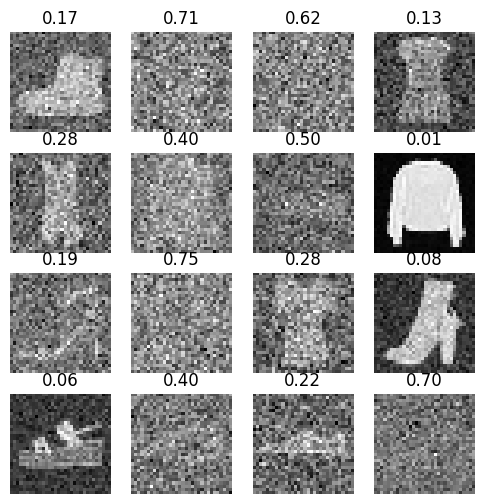

In [ ]:
(ims, ts), _ = add_noise(xb[:16])
show_images(ims, imsize=1.5, titles=list(map(lambda x: f"{x:.2f}", ts)));

In [ ]:
def get_collate_ddpm():
    def _collate_ddpm(b):
        return add_noise(default_collate(b)[fm_x])
    return _collate_ddpm

collate_ddpm = get_collate_ddpm()

In [ ]:
def dl_ddpm(ds):
    return DataLoader(ds, batch_size=bs*2, collate_fn=collate_ddpm, num_workers=4)

In [ ]:
class UNet(UNet2DModel):
    def forward(self, x):
        return super().forward(*x).sample

In [ ]:
def init_ddpm(model):
    for down_block in model.down_blocks:
        for resnet in down_block.resnets:
            resnet.conv2.weight.data.zero_()
        downsamplers = down_block.downsamplers
        if not downsamplers: downsamplers = []
        for downsampler in downsamplers:
            init.orthogonal_(downsampler.conv.weight)

    model.conv_out.weight.data.zero_()

In [ ]:
dls = DataLoaders(dl_ddpm(dst["train"]), dl_ddpm(dst["test"]))

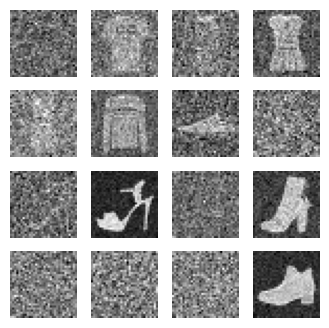

In [ ]:
xb, yb = next(iter(dls.train))
show_images(xb[0][:16], imsize=1);

loss,epoch,train
0.231,0,train
0.052,0,valid
0.048,1,train
0.044,1,valid
0.043,2,train
0.043,2,valid
0.040,3,train
0.040,3,valid
0.038,4,train
0.037,4,valid


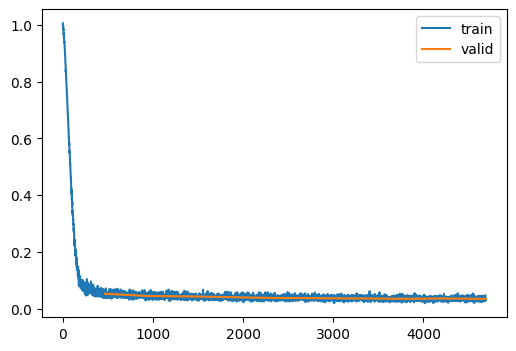

In [ ]:
set_seed(1103, False)
lr = 0.002
epochs = 10
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))
cbs = [DeviceCB(), ProgressCB(True), MetricsCB(), sched]

model = UNet(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=16)
init_ddpm(model)

opt_func = partial(optim.AdamW, eps=1e-4)

learn = TrainLearner(model, dls, F.mse_loss, lr=lr, cbs=cbs, opt_func=opt_func)
learn.fit(epochs)

In [ ]:
model_path = Path("models")
model_path.mkdir(exist_ok=True)
torch.save(learn.model, model_path / "22_cosine_10.pkl")

In [ ]:
model_path = Path("models")
model = torch.load(model_path / "19_ddpm_v3_lincos_10.pkl").cuda()

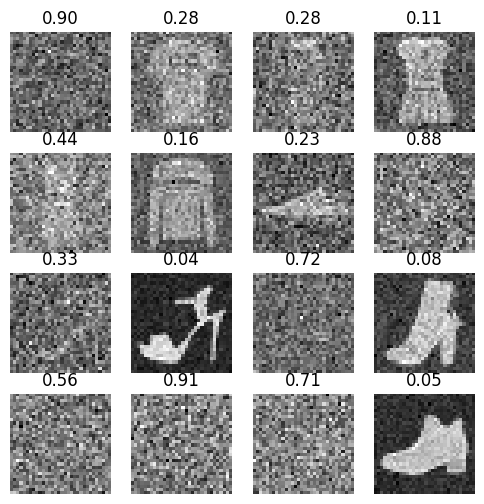

In [ ]:
show_images(xb[0][:16], imsize=1.5, titles=list(map(lambda t: f"{t:.2f}", ts)));

In [ ]:
ims = xb[0][:16].cuda()
ts = xb[1][:16].cuda()

In [ ]:
with torch.no_grad():
    noise = model((ims, ts))

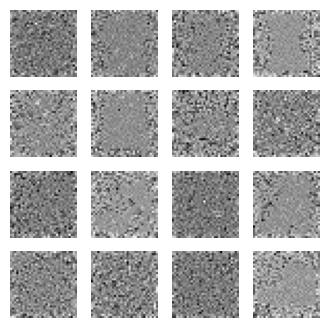

In [ ]:
show_images(noise, imsize=1);

In [ ]:
# ims = original_part + noise_part = abt.sqrt() * x + (1 - abt).sqrt() * noise 
# x = (ims - (1 - abt).sqrt() * noise) / abt.sqrt()
abt = abar(ts).reshape(-1, 1, 1, 1)
denoised_ims = (ims - (1 - abt).sqrt() * noise) / abt.sqrt()

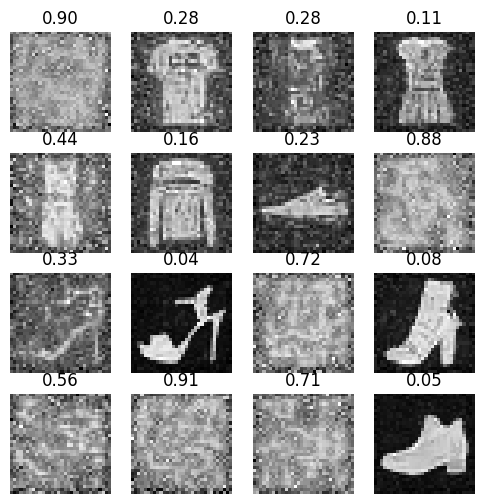

In [ ]:
show_images(denoised_ims, imsize=1.5, titles=list(map(lambda t: f"{t:.2f}", ts)));

In [ ]:
denoised_ims.min(), denoised_ims.max()

(tensor(-11.2486, device='cuda:0'), tensor(6.8741, device='cuda:0'))

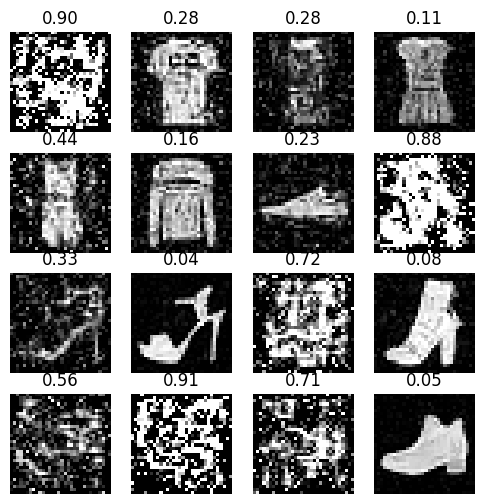

In [ ]:
show_images(denoised_ims.clip(-0.5, 0.5), imsize=1.5, titles=list(map(lambda t: f"{t:.2f}", ts)));

In [ ]:
def denoise(x_t, noise, t):
    device = x_t.device
    abt = abar(t).reshape(-1, 1, 1, 1).to(device)
    return (x_t - (1 - abt).sqrt() * noise) / abt.sqrt()

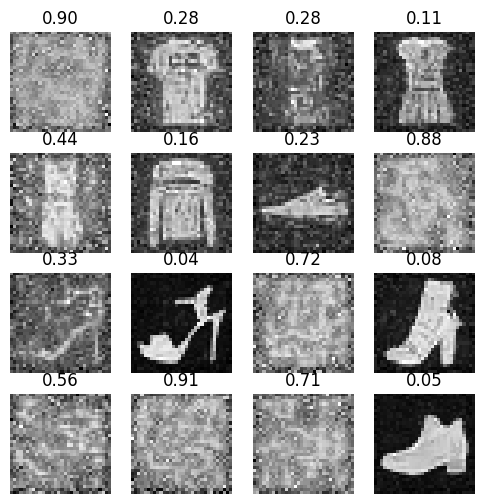

In [ ]:
show_images(denoise(ims, noise, ts), imsize=1.5, titles=list(map(lambda t: f"{t:.2f}", ts)));

# Sampling

In [ ]:
@inplace
def transformi2(b):
    b["image"] = [TF.pad(TF.to_tensor(i), padding=2, fill=0, padding_mode="constant") * 2 - 1 for i in b["image"]]
dst2 = ds.with_transform(transformi2)

bs2 = 256
dls2 = DataLoaders.from_dd(dst2, bs2)

fid_model = torch.load('models/14_aug_for_fid.pkl')
del fid_model[8]
del fid_model[7]

image_eval = ImageEval(fid_model, dls2, cbs=[DeviceCB()])

In [ ]:
def ddim_step(x_t, t, noise, alpha_bar_t, alpha_bar_t_minus_1, beta_bar_t, beta_bar_t_minus_1, eta, clipv=2):
    # Equation (12)
    predicted_coef = alpha_bar_t_minus_1.sqrt()
    predicted_x0 = ((x_t - beta_bar_t.sqrt() * noise) * (1 / alpha_bar_t.sqrt())).clip(-clipv, clipv)
    sigma_t = (beta_bar_t_minus_1 / beta_bar_t).sqrt() * (1 - alpha_bar_t / alpha_bar_t_minus_1).sqrt() * eta
    if sigma_t.isnan().item():
        sigma_t = 0
    noise_coef = beta_bar_t_minus_1 - sigma_t ** 2
    if noise_coef < 1e-5:
        noise_coef = beta_bar_t_minus_1
    direction_to_x_t = (beta_bar_t_minus_1 - sigma_t ** 2).sqrt() * noise
    random_noise = sigma_t * torch.randn(x_t.shape, device=x_t.device) if t > 0 else 0
    x_t_minus_1 = predicted_coef * predicted_x0 + direction_to_x_t + random_noise
    return x_t_minus_1

In [ ]:
def sample(f, model, sz, steps, eta=1.):
    ts = torch.linspace(0.99, 0, steps)
    # ts = [*torch.linspace(0.99, 0.3, steps // 3), *torch.linspace(0.3, 0.1, steps // 3), *torch.linspace(0.1, 0., steps // 3),]
    device = next(model.parameters()).device
    with torch.no_grad():
        x = torch.randn(sz, device=device)
        bs = x.shape[0]
        process = []

        for idx, t in enumerate(progress_bar(ts)):
            t_batch = torch.full((bs,), t, dtype=torch.int64, device=device)
            noise_pred = model((x, t_batch))

            alpha_bar_t = abar(t)
            alpha_bar_t_minus_1 = abar(t - 1 / steps) if t > 1 / steps else torch.tensor(1)
            beta_bar_t = 1 - alpha_bar_t
            beta_bar_t_minus_1 = 1 - alpha_bar_t_minus_1
            x = f(x, t, noise_pred, alpha_bar_t, alpha_bar_t_minus_1, beta_bar_t, beta_bar_t_minus_1, eta)

            process.append(to_cpu(x))
    return process

In [ ]:
%time generated = sample(ddim_step, model, (2, 1, 32, 32), 100)
final = generated[-1] * 2

CPU times: user 2.94 s, sys: 97.9 ms, total: 3.04 s
Wall time: 3.04 s


In [ ]:
final.min(), final.max()

(tensor(-1.3873), tensor(2.1861))

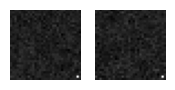

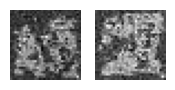

In [ ]:
show_images(generated[20][:16] * 2, imsize=1);
show_images(generated[80][:16] * 2, imsize=1);

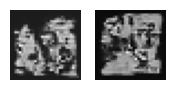

In [ ]:
show_images(final[:16], imsize=1);

In [ ]:
image_eval.fid(final), image_eval.kid(final)

(1261.506103515625, 5.223779678344727)